# Autoencoders for image quality improvement with Omhu

Installations and imports: 

In [ ]:
%matplotlib inline
#!pip install torch
#!pip install torchvision
#!pip install torchsummary 

import matplotlib.pyplot as plt
import numpy as np
import random

import torch

cuda = torch.cuda.is_available()

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn

from torchsummary import summary

#from google.colab import drive
#from google.colab import files

## 1. Loading CIFAR10 dataset

We will start the project by loading the CIFAR-10 dataset, which contains 10 classes of images of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size. The total number of images in the CIFAR-10 dataset is 60000, 6000 images for each class. The dataset is divided into two groups, training and testing images: 50,000 training images, 10,000 testing images (there are 500 training images and 100 testing images per class). Later, we will simulate the common image quality issues that we can find in images taken and uploaded by a patient from his mobilephone (e.g. reflection, rotation, blur, poor lighting, pixelated images). For now, we will just focus in brightness issue.

Using ``torchvision``:

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', download =True, train=True, transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3,5)

    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]
        

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=400,
                                          shuffle=True, num_workers=2, pin_memory=cuda)
testloader = torch.utils.data.DataLoader(testset, batch_size=400,
                                         shuffle=True, num_workers=2, pin_memory=cuda)

train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1]. Normalizing the data should help the performance of the CNN. Our dataset is already within [0,1], therefore we do not need to re-normalize.

We can visualize now some of the images we are working with:

Tensor values range:  tensor(0.) tensor(1.)


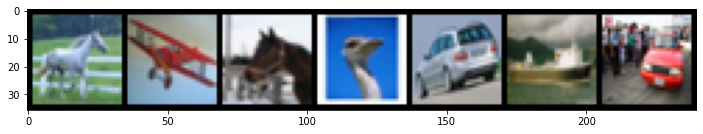

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img, recon=None):
    """ show an image """
    npimg = img.numpy()
    if recon != None: 
      nprecon = recon.detach().numpy()
      fig = plt.figure(figsize=(12, 12))
      ax1 = fig.add_subplot(2,1,1)
      ax1.imshow(np.transpose(npimg, (1, 2, 0)))
      ax2 = fig.add_subplot(2,1,2)
      ax2.imshow(np.transpose(nprecon, (1, 2, 0)))
    else:
      plt.figure(figsize = (12,12))
      plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images,_ = train_data_iter.next()
print('Tensor values range: ',torch.min(images), torch.max(images))

# show images
imshow(torchvision.utils.make_grid(images[:7]))

## 2. Autoencoders for image quality improvement

The main task in this project is to use autoencoders in order to improve the quality of smartphone images sent by customers to Omhu, to facilitate the process of diagnosing skin conditions. 

The CIFAR10 dataset will allow us to simulate this goal by using the images contained in this dataset as high quality images and transforming them to mimic the common quality issues. 

### 2.1. Autoencoders

For encoding and decoding we could simply use a feed forward Neural Net, but in the case of images we generally use a Convolutional Neural Net, which usually performs better. Our model is a generative model because here instead of classifying images, we want to generate images based on the encoding.

For autoencoders, instead of thinking about all transformations as operations in one way, we can think of this as a forth and back operation. We encode in one direction and then we want to go in the opposite direction and decode it to get the original image. So for each transformation we apply in the encoder we want to apply the inverse of this operation in the decoder. 

See this structure for a very simple linear autoencoder:

In [ ]:
# LINEAR 

class Autoencoder_Linear(nn.Module):
    def __init__(self):
        # N, 32x32=1024
        super().__init__() # super() returns a delegate object to a parent class, so you call the method you want directly on it
        
        # use a sequential model (we want to repeatedly apply linear layers)
        # Encoder 
        self.encoder = nn. Sequential(
            nn.Linear(32*32, 128), 
            nn.ReLU(), # <- activation function.
            nn.Linear(128,64),
            nn.ReLU(), 
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3) # final output size -> N, 3. This will drastically reduce our image size.
            # in the last layer we don't need an activation function.
        )
        
        # Now we want to do the same in the opposite direction 
        # Decoder
        self.decoder = nn. Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(), 
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,32*32),
            # We know that our images have values between 0 and 1; hence, we need an activation function that puts the values in exactly the range [0,1]->  sigmoid function:
            nn.Sigmoid()
        )
    
    # In the forward pass we simply apply our encoder and decoder: 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


For CNNs we apply convolutional layers (nn.Conv2d) so the inverse is actually called a transpose convolution (nn.ConTranspose2d).

### 2.2. Creating our Autoencoder class (this is our model)

CNNs are made up of neurons that have learnable weights and biases. They apply convolutional filters over images, which work by applying a filter kernel to our images. This application is called convolution and results in an activation. The kernel is used for blurring, sharpening, embossing, edge detection...

We add pooling layers (max pooling in this case) to down sample the images. This makes the data of a more manageable size, allows us to reduce the dimensionality of the images thus enabling in faster processing of the data and, reduces the number of parameters our model has to learn and helps to avoid overfitting by providing an abstracted form of the input.

For the first part of the project we will just modify the image's brightness.

We start with a very simple CNN consisting of 3 convolution layers, ReLU activation function and MaxPool layers:

In [ ]:
# CONV(3) + MAXPOOLING

class Autoencoder_CNN1(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32, 32
        super().__init__()

        # Encoder
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(), 

            nn.Conv2d(32, 64, 8)
        )
        
        # Decoder
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(64, 32, 8), 
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(), 
            
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

We reached a train loss of 0.0175 by the 41st epoch. In the results we can see that there has been some correction in the brightnes despite the images being quite blurry. It is important to mention that when plotting the validation and the training errors, they are quite approximate. As we will see in the following models, this is not something found very often in the model trainings we performed.

#### + BatchNorm

Trying to improve the previous model, we add Batch normalization. This method enables to make the CNN faster and more stable through normalization of the layer's inputs by standarizing the inputs to a layer for each mini-batch. It stabilizes the learning process and reduces the number of epochs required to train deep networks; this is, batch normalization accelerates training.  



In [ ]:
# CONV(3) + MAXPOOLING + BATCHNORM

class Autoencoder_CNN2(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32, 32 
        super().__init__()

        # Encoder
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(), 

            nn.Conv2d(32, 64, 8)
        )
        
        # Decoder
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(64, 32, 8),  
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(), 

            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

and reached a train loss of 0.00963, which is a significant improvement respect to our previous model.  Adding batch normalization makes the model better in just a few epochs. 

#### + Linear layer

Another approach could be combining linear layers with convolutional layers. In this case we tried to add three linear layers after the convolutions.

In [ ]:
# CONV(2) + MAXPOOLING + BATCHNORM + LINEAR(3)

class Autoencoder_CNN3(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32, 32 
        super().__init__()

        # Encoder
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(32, 64, 8),
 
            nn.Flatten(),
            nn.Linear(64*1*1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8))
        
        # Decoder
        self.decoder = nn. Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64*1*1),
            nn.Unflatten(1, (64,1,1)),

            nn.ConvTranspose2d(64, 32, 8), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(), 
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),   
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

Gets a MSE train loss of aprox. 0.0275. There is no improvement at all respect to our previous model. Moreover, the behaviour of this model is considerably worse than the one of just convolutions with batch normalization. Adding linear layers is not a good choice for our application. We tried also adding an only last linear layer, what ended up in a better result but still worse than without any linear layer (approx. 0.0227 train loss). 

In [ ]:
# CONV(2) + MAXPOOLING + BATCHNORM + LINEAR(1)

class Autoencoder_CNN3b(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32, 32 
        super().__init__()
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(), 

            nn.Conv2d(32, 64, 8),

            nn.Flatten(),
            nn.Linear(64*1*1, 8))
        
        # Now we need to do the opposite
        self.decoder = nn. Sequential(
            nn.Linear(8, 64),
            nn.Unflatten(1, (64,1,1)),

            nn.ConvTranspose2d(64, 32, 8), 
             #Hout = (hin - 1)*stride + padding * 2 + kernel
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### + More convolutional layers  

Next we tried to pich our CNN2 (CONV + MAXPOOLING + BATCHNORM) and make it deeper with 5 convolutional layers instead of 3.

In [ ]:
# CONV(5) + MAXPOOLING + BATCHNORM

class Autoencoder_CNN4(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32,32 
        super().__init__()
        # Encoder
        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 1, 1),
            nn.BatchNorm2d(64),
 
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 1,1), 
            nn.BatchNorm2d(128),
 
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3,1,1),
            nn.BatchNorm2d(256))
        

        # Decoder
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(256, 128, 2), 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

this model reached a MSE training loss of 0.0088 along the 50 trained epochs. What improved slightly our model. The output corrected images let us recognise a bit better the main element in the picture but the reconstruction is still pretty blurry. Nevertheless, a slight correction in the brightness can be perceived. 

#### - Maxpooling + upsampling

Maxpooling downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window, until now chosen to be of size 2-by-2, for each channel of the input. This is, most probably, the main reason for which the outputs of our previous models were very blurry. We decided not to do maxpooling this time, with the objective of getting more sharp images, and considering that the resolution of our images is not to big to handle and we should proceed okay without pooling. Moreover, we decided to add an upsampling layer in an attempt to increase the resolution of our images due to their small size. 

In [ ]:
# CONV(5) + BATCHNORM + UPSAMPLING

class Autoencoder_CNN6(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32, 32
        super().__init__()

        # Encoder
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=0), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=2, padding=0),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=1, padding=0), 
            nn.BatchNorm2d(32),
            nn.UpsamplingBilinear2d(scale_factor=2),  
            nn.ReLU(),
            
            nn.Conv2d(32, 32, 3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, 1, stride=1, padding=0)) 
            
        
        # Decoder
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(3, 32, 1), 

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=0, output_padding=0),

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=0.5),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=0, output_padding=0),

            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=1),
            
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=0, output_padding=0),

            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

and reached a loss of 0.0075; the lowest until now. The reconstruction of the images is in this case much closer to the oridinal images than in the remaining cases. This will potentially be our best model in this notebook.

#### Keep size unchanged


In this case we just wanted to check that applying convolutions keeping the same image size is not useful for our model.

In [ ]:
# CONV(3) + MAXPOOLING

class Autoencoder_CNN7(nn.Module):   # does not improve performance
    def __init__(self):
        super().__init__()
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(), 

            nn.Conv2d(32, 32, 8)
        )
        
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(32, 32, 8), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(), 
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

High losses, no lower than 0.01659.

#### + Maxpooling + Batchnorm + Upsampling

Here we try first to reduce the dimension of the image by maxpooling to later expand it using upsampling. 


In [ ]:
# CONV(3) + MAXPOOLING + BATCHNORM + UPSAMPLING

class Autoencoder_CNN8(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ReLU(), 
            
            nn.Conv2d(32, 64, 8))
        
        self.decoder = nn. Sequential(

            nn.ConvTranspose2d(64, 32, 8), 
            nn.UpsamplingBilinear2d(scale_factor=0.5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

We runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

The lowest loss was reached with this model, 0.0074. Nevertheless, for now we will keep Autoencoder_CNN6 since the reconstruction it provides is much more sharp than the one given by this last model. In terms of brightness correction, both perform similar. A longer training could improve this.

__We decided to work on CNN6 to perform a larger training and see its results. Also, we will try different optimizers, to see if we can find any that provides a better model performance. This will be done in the notebook Autoencoders_CNN6.ipynb.__

 In order to train our model, we need a loss function that we want to optimize (minimize). We want our reconstructed image to be as close as possible to the original one, so all pixel values should be almost the same between the reconstructed image and the original one. Our loss function is the Mean Squared Error (MSE) which calculates the difference between all intensity values sums over all pixels and then calculates the mean value. 

The chosen optimizer is the Adam optimizer, which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [ ]:
model = Autoencoder_CNN6()

if cuda:
    model = model.cuda()

criterion = nn.MSELoss()
#nn.BCELoss()  BinaryCrossEntropy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 

In [ ]:
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           9,248
       BatchNorm2d-7           [-1, 32, 12, 12]              64
UpsamplingBilinear2d-8           [-1, 32, 24, 24]               0
              ReLU-9           [-1, 32, 24, 24]               0
           Conv2d-10           [-1, 32, 22, 22]           9,248
      BatchNorm2d-11           [-1, 32, 22, 22]              64
             ReLU-12           [-1, 32, 22, 22]               0
           Conv2d-13            [-1, 3, 22, 22]              99
  ConvTranspose2d-14           [-1, 3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


# Train the network on transformed data

We have tried different approaches when training our models. We performed training on just transformed images, on transformed images together with  original images, and first with original images to later train with transformed images. 

In [ ]:
#drive.mount('/content/gdrive')

In [ ]:
num_epochs = 50
outputs = []
orig_ims = []
recon_ims = []
train_loss = []
val_loss = []
color_jitter = transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0)
for epoch in range(num_epochs):
    model.train()
    for (img, _) in trainloader:
        if cuda:
            img = img.cuda()
        if random.uniform(0, 1) < 0.05:
          recon = model(color_jitter(img))
        else:
          recon = model(img)  # get the reconstructed image
        loss = criterion(recon, img)   # calculate the MSE between the original image and the reconstructed image
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
     
    train_loss.append(loss.item())    

    # Evaluate gradients
    with torch.no_grad():
      model.eval()
    # Just load a single batch from the test loader
      x, _ = next(iter(testloader))
      if cuda:
          x = x.cuda()
      recon_x = model(color_jitter(x))
      loss_x = criterion(recon_x, x)
      val_loss.append(loss_x.item())

    print(f'Epoch:{epoch+1}, Loss:{train_loss[-1]:.4f}, Val_Loss:{loss_x.item():.4f}') 
    if epoch == 0:
        continue

    orig_ims.append(img)  
    recon_ims.append(recon)  
    outputs.append((epoch, x, recon_x)) # store the epoch, the image and the reconstructed image in the outputs list
    if  ((len(train_loss)>1) and (train_loss[-1] < min(train_loss[:-1]))): 
       state_dics = model.state_dict()
       print('new_minloss_epoch: ',epoch+1,' with new_min_loss: ', train_loss[-1]) 
    elif len(train_loss)==1:
      state_dics = model.state_dict()

    

torch.save(state_dics, '/content/best-model-parameters_CNN6.pth')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Epoch:1, Loss:0.0161, Val_Loss:0.1529
Epoch:2, Loss:0.0130, Val_Loss:0.0623
new_minloss_epoch:  2  with new_min_loss:  0.013007034547626972
Epoch:3, Loss:0.0119, Val_Loss:0.1741
new_minloss_epoch:  3  with new_min_loss:  0.01187320239841938
Epoch:4, Loss:0.0154, Val_Loss:0.2075
Epoch:5, Loss:0.0103, Val_Loss:0.0850
new_minloss_epoch:  5  with new_min_loss:  0.010342178866267204
Epoch:6, Loss:0.0105, Val_Loss:0.1351
Epoch:7, Loss:0.0104, Val_Loss:0.0155
Epoch:8, Loss:0.0096, Val_Loss:0.0843
new_minloss_epoch:  8  with new_min_loss:  0.009564838372170925
Epoch:9, Loss:0.0093, Val_Loss:0.0253
new_minloss_epoch:  9  with new_min_loss:  0.009275379590690136
Epoch:10, Loss:0.0092, Val_Loss:0.1111
new_minloss_epoch:  10  with new_min_loss:  0.009202818386256695
Epoch:11, Loss:0.0089, Val_Loss:0.0242
new_minloss_epoch:  11  with new_min_loss:  0.008903924375772476
Epoch:12, Loss:0.0091, Val_Loss:0.0615
Epoch:13, Loss:0.0084, Val_Loss:0.1309
new_minloss_epoch:  13  with new_min_loss:  0.0083787

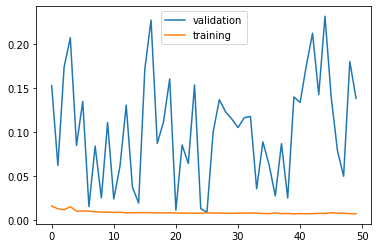

In [ ]:
plt.plot(val_loss, label = "validation")
plt.plot(train_loss, label = "training")
plt.legend()

During the training we have saved the best model we got. With the next line of code we could load any model previously saved to run it on our test data set without the need of training it again.

In [ ]:
#state_dics = torch.load('/content/#best-model-parameters_CNN6.pth')
print(state_dics.keys())

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.3.weight', 'encoder.3.bias', 'encoder.5.weight', 'encoder.5.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.6.running_mean', 'encoder.6.running_var', 'encoder.6.num_batches_tracked', 'encoder.9.weight', 'encoder.9.bias', 'encoder.10.weight', 'encoder.10.bias', 'encoder.10.running_mean', 'encoder.10.running_var', 'encoder.10.num_batches_tracked', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.1.weight', 'decoder.1.bias', 'decoder.1.running_mean', 'decoder.1.running_var', 'decoder.1.num_batches_tracked', 'decoder.3.weight', 'decoder.3.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.4.running_mean', 'decoder.4.running_var', 'decoder.4.num_batches_tracked', 'decoder.7.weight', 'decoder.7.bias', 'decoder.9.weight', 'decoder.9.bias', 'decoder.10.weight', 'decoder

In [ ]:
model.load_state_dict(state_dics)
best_model = model.eval()
best_model = best_model.cuda()
print(best_model)

Autoencoder_CNN6(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

# Test the network on test data

Now we need to check if the network has learnt anything at all. We will check this by recreating the clean image that the neural network outputs, and checking it against the original image. Let us display some unseen images:

Desired images:


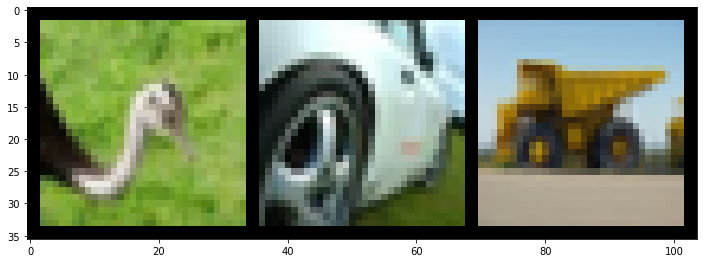

Input images: 


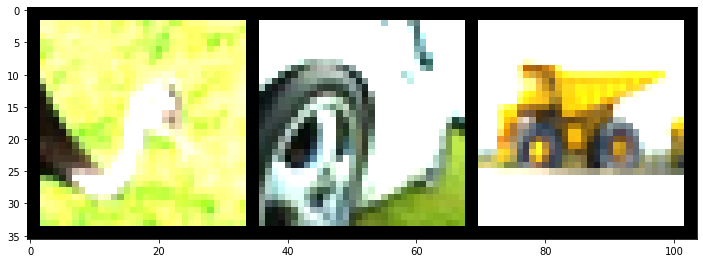

Reconstructed images: 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


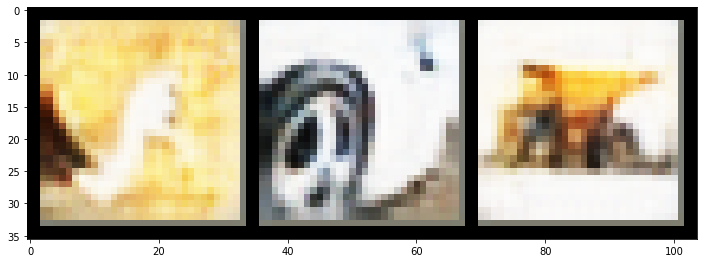

In [ ]:
images, _ = test_data_iter.next()
images.cuda()

# print desired (original) images
print('Desired images:')
imshow(torchvision.utils.make_grid(images[:3]))
plt.show()

# print transformed images: 
print('Input images: ')
transf_images = color_jitter(images)
imshow(torchvision.utils.make_grid(transf_images[:3]))
plt.show()

# print reconstructed images: 
print('Reconstructed images: ')
outputs = best_model(transf_images.cuda()).cpu()
#_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(outputs[:3]))